# Goals

Modeling the time it takes to close issues, and eventually a deeper analysis the relationship between time it takes to close, and the types of issues that exist.

In [1]:
# Import useful packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('./Improve_Detroit_Issues.csv', header = 0)
data.head()

,X,Y,id,status,request_type_title,description,web_url,report_method,priority_code,created_at,...,closed_at,reopened_at,updated_at,days_to_close,canonical_issue_id,address,neighborhood,council_district,oid,geom
0,-82.922541,42.399903,9630294,Acknowledged,Investigate Blocked Basin Street,storm water backflow into my basement,https://seeclickfix.com/issues/9630294,direct,2,2021/04/01 06:05:38+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 06:05:45+00,NaN,NaN,"3981 Guilford St Detroit, MI 48224, USA",NaN,NaN,1,NaN
1,-83.232881,42.333398,9629814,Acknowledged,Investigate Blocked Basin Street,Sewer Water has been pouring into my basement ...,https://seeclickfix.com/issues/9629814,direct,2,2021/04/01 04:50:04+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 04:50:28+00,NaN,NaN,"6073 Auburn St Detroit MI 48228, United States",NaN,NaN,2,NaN
2,-83.107571,42.436438,9629750,Open,Traffic Complaints,Person lighting fireworks and loud explosives ...,https://seeclickfix.com/issues/9629750,direct,2,2021/04/01 04:20:51+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 04:20:51+00,NaN,NaN,"400 Annin St Detroit MI 48203, United States",NaN,NaN,3,NaN
3,NaN,NaN,9629710,Open,Abandoned Vehicle,Redacted,https://seeclickfix.com/issues/9629710,direct,2,2021/04/01 04:00:45+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 04:00:47+00,NaN,NaN,Redacted,NaN,NaN,4,NaN
4,-83.223464,42.346134,9629705,Open,Reboard House Request,This home is burnt down. Dumping is starting ...,https://seeclickfix.com/issues/9629705,direct,2,2021/04/01 03:58:55+00,...,1970/01/01 00:00:00+00,1970/01/01 00:00:00+00,2021/04/01 03:59:01+00,NaN,NaN,"7395 Brace St Detroit, MI 48228, USA",NaN,NaN,5,NaN


# Exploration of time it takes to close issues

## Let's look at how long it takes to close an issue by the month

In [43]:
# There's already a column documenting the time it took to close the issue. However there are a lot of nulls values.
month = pd.to_datetime(data['created_at']) # convert to a datetime object
month = month.apply(lambda x: x.month) # apply and grab the integer representing the month. 

monthClose = pd.concat([month, data['days_to_close']], axis = 1)
monthClose.rename(columns = {'created_at':'month'}, inplace=True)


### Plotting linear fit

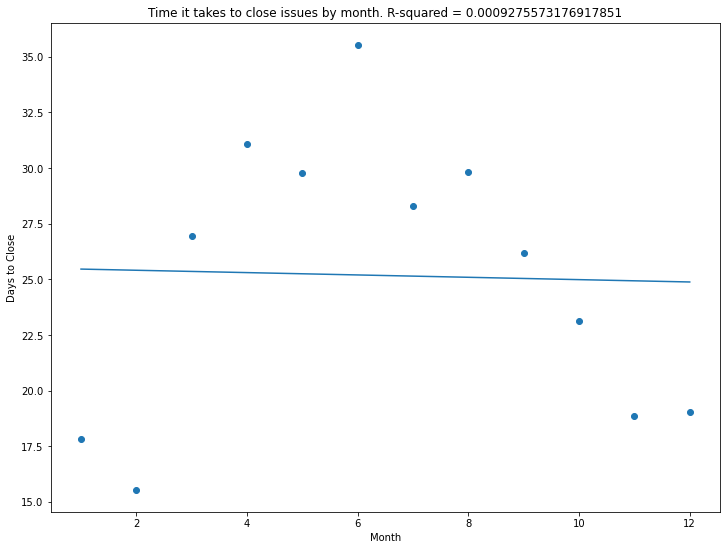

In [69]:
from sklearn.linear_model import LinearRegression

x = np.arange(1,13).reshape(-1,1)
y = monthClose.groupby('month').mean()

model = LinearRegression()
model.fit(x,y)
y_pred = model.coef_*x + model.intercept_

plt.figure(figsize = (12,9))
plt.scatter(x, y)
plt.plot(x, y_pred)
plt.ylabel('Days to Close')
plt.xlabel('Month')
plt.title('Time it takes to close issues by month. R-squared = {}'.format(model.score(x,y)))
plt.show()

Now that's interesting! There's obviously a quadratic relationship between the month, and the amount of days it takes to close the issue. A linear model is clearly not the right way to model this data.

### Plotting quadratic fit

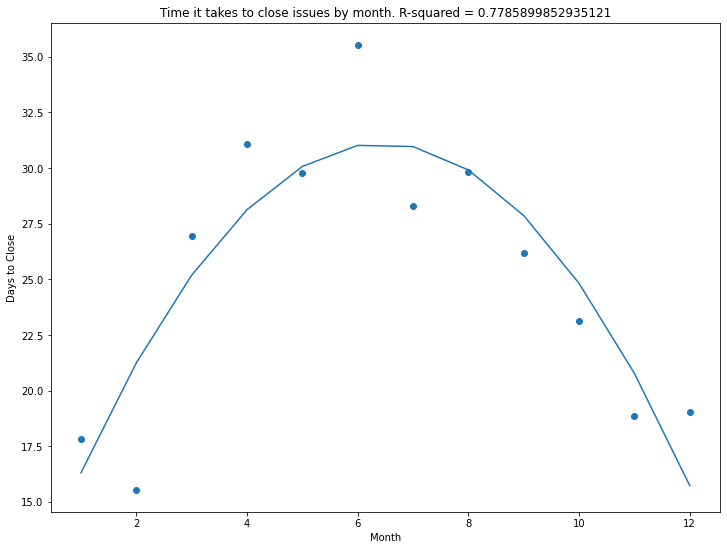

In [68]:
from sklearn.preprocessing import PolynomialFeatures

x = np.arange(1,13).reshape(-1,1)
x2 = x ** 2
x_quad = np.concatenate((x, x2), axis = 1)
x_quad.reshape(-1, 2)
y = monthClose.groupby('month').mean()

model = LinearRegression()
model.fit(x_quad,y)
y_pred = model.predict(x_quad)

plt.figure(figsize = (12,9))
plt.scatter(x, y)
plt.plot(x, y_pred)
plt.ylabel('Days to Close')
plt.xlabel('Month')
plt.title('Time it takes to close issues by month. R-squared = {}'.format(model.score(x_quad,y)))
plt.show()

Much better, and we're getting a pretty decent R-squared term as well. Evidently, there's a concave down relationship between month and time it takes to close issues. This seems counterintuitive, as it feels like holiday months (later in the Fall and early Winter) would be when it takes issues longest. However, it seems like the summer months take the absolute longest, with June take even more than a month to close. 

Yet, this does not tell the full story, as the amount of time it takes to close may very well depend on the types of issues that show up during the year. The next step is to figure out what kinds of issues appear during which months.